K fold: 10 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

2024-01-11 05:08:13.379489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 05:08:15.379476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 05:08:15.386183: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

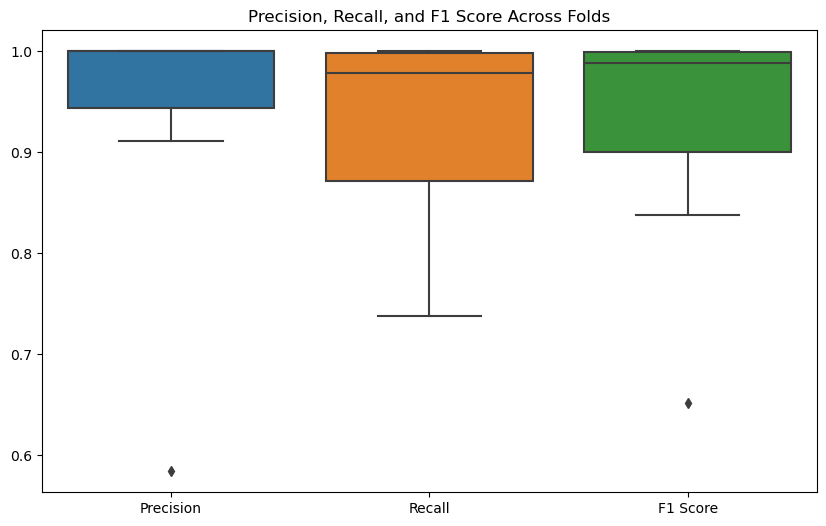


Summary of Results:
   Fold  Accuracy  Precision   Recall  F1 Score
0     1  0.606250   0.584158  0.73750  0.651934
1     2  0.856250   0.959677  0.74375  0.838028
2     3  0.903125   0.938776  0.86250  0.899023
3     4  0.906250   0.911392  0.90000  0.905660
4     5  1.000000   1.000000  1.00000  1.000000
5     6  0.996875   1.000000  0.99375  0.996865
6     7  0.981250   1.000000  0.96250  0.980892
7     8  1.000000   1.000000  1.00000  1.000000
8     9  0.996875   1.000000  0.99375  0.996865
9    10  1.000000   1.000000  1.00000  1.000000


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)


Precision List: [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
Recall List: [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
F1 List: [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]


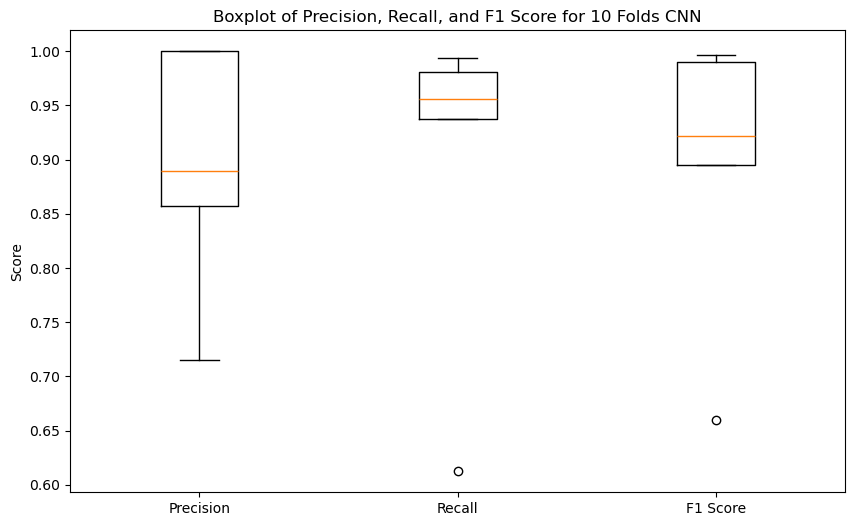

ValueError: All arrays must be of the same length

In [11]:
import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)

import matplotlib.pyplot as plt

# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score for 10 Folds CNN')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



K fold: 5 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


2024-01-07 06:42:30.869819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 06:42:32.256520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 06:42:32.264014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

This code below is for K fold: 5 folds, 80%-20% train/test split, but it includes evluation metrics, boxplot and summary table 

1-10-23

2024-01-10 16:42:35.995061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

2024-01-10 16:42:37.173100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 16:42:37.180220: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Fold 1 - Training Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split/fold1/Training
Found 1440 images belonging to 2 classes.
Number of Training Samples: 1440

Fold 1 - Testing Data Directory: /home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split/fold1/Testing
Found 320 images belonging to 2 classes.
Number of Test Samples: 320
Epoch 1/60
45/45 [==============================] - 24s 500ms/step - loss: 1.0862 - accuracy: 0.5931
Epoch 2/60
45/45 [==============================] - 22s 476ms/step - loss: 0.6127 - accuracy: 0.6729
Epoch 3/60
45/45 [==============================] - 21s 463ms/step - loss: 0.5982 - accuracy: 0.6722
Epoch 4/60
45/45 [==============================] - 21s 466ms/step - loss: 0.5538 - accuracy: 0.7083
Epoch 5/60
45/45 [==============================] - 21s 462ms/step - loss: 0.5230 - accuracy: 0.7271
Epoch 6/60
45/45 [==============================] - 21s 454ms/ste

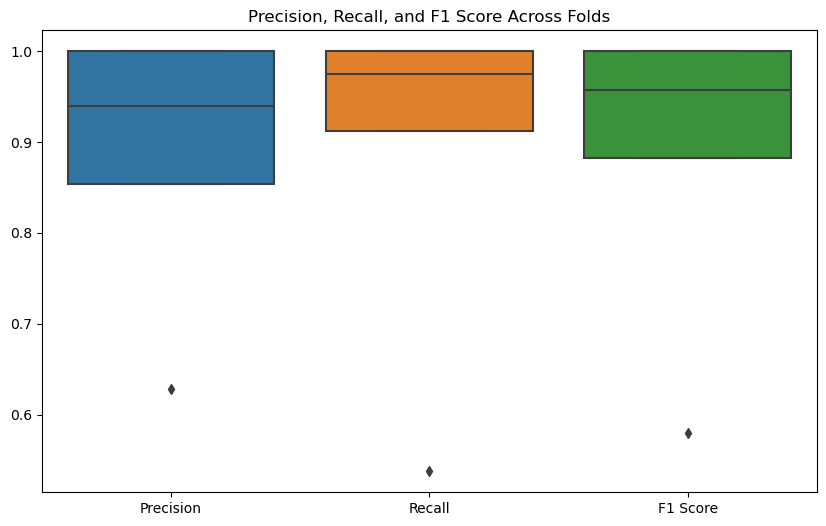


Summary of Results:
   Fold  Accuracy  Precision  Recall  F1 Score
0     1  0.609375   0.627737  0.5375  0.579125
1     2  0.878125   0.853801  0.9125  0.882175
2     3  0.956250   0.939759  0.9750  0.957055
3     4  1.000000   1.000000  1.0000  1.000000
4     5  1.000000   1.000000  1.0000  1.000000


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)


In [4]:
import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


Precision List: [0.6277372262773723, 0.8538011695906432, 0.9397590361445783, 1.0, 1.0]
Recall List: [0.5375, 0.9125, 0.975, 1.0, 1.0]
F1 List: [0.5791245791245792, 0.8821752265861027, 0.9570552147239264, 1.0, 1.0]


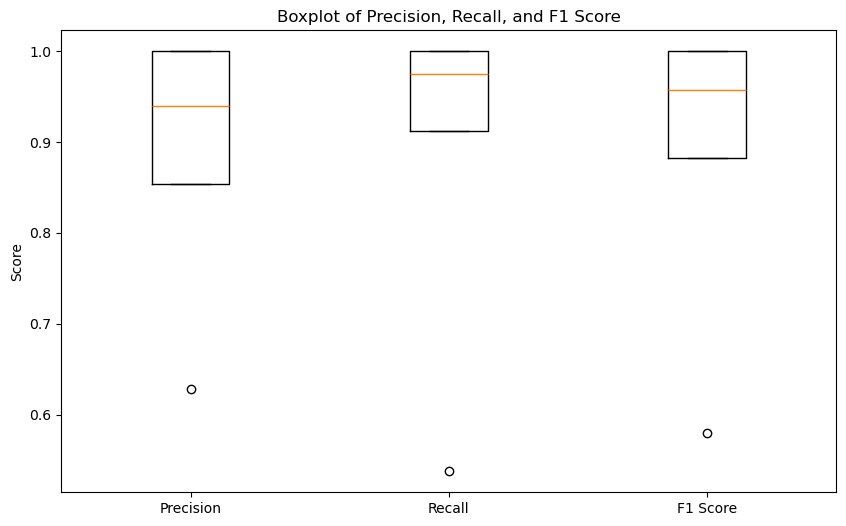

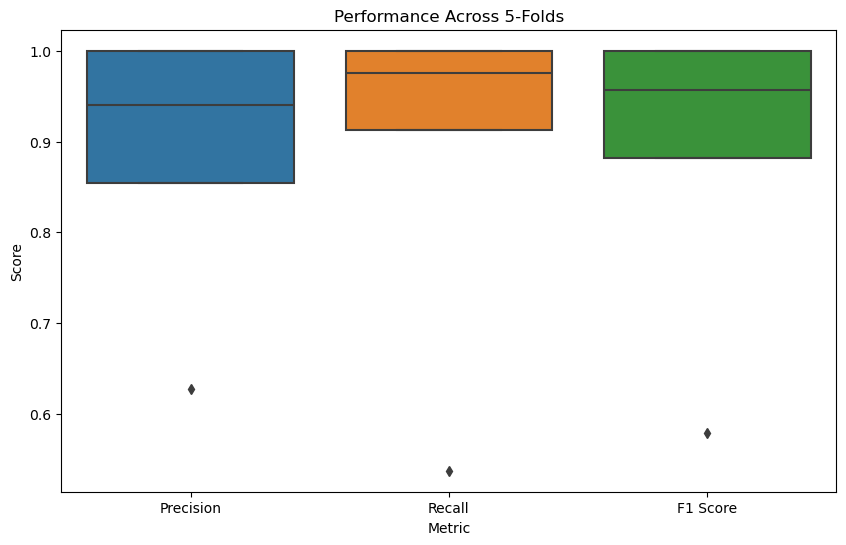


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
F1 Score     0.579125   0.883671        1.0
Precision    0.627737   0.884259        1.0
Recall       0.537500   0.885000        1.0


In [9]:
import matplotlib.pyplot as plt

# Data
precision_list = [0.6277372262773723, 0.8538011695906432, 0.9397590361445783, 1.0, 1.0]
recall_list = [0.5375, 0.9125, 0.975, 1.0, 1.0]
f1_list = [0.5791245791245792, 0.8821752265861027, 0.9570552147239264, 1.0, 1.0]

# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()
# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)


(THIS IS MY SECOND ATTEMPT RUNNING THIS BECAUSE I FEEL LIKE THE NUMBERS ARE TOO GOOD) 1-11-23
This code below is for K fold: 5 folds, 80%-20% train/test split, but it includes evluation metrics, boxplot and summary table 

UPDATE: THIS IS THE ONE FOR 5 FOLD!

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

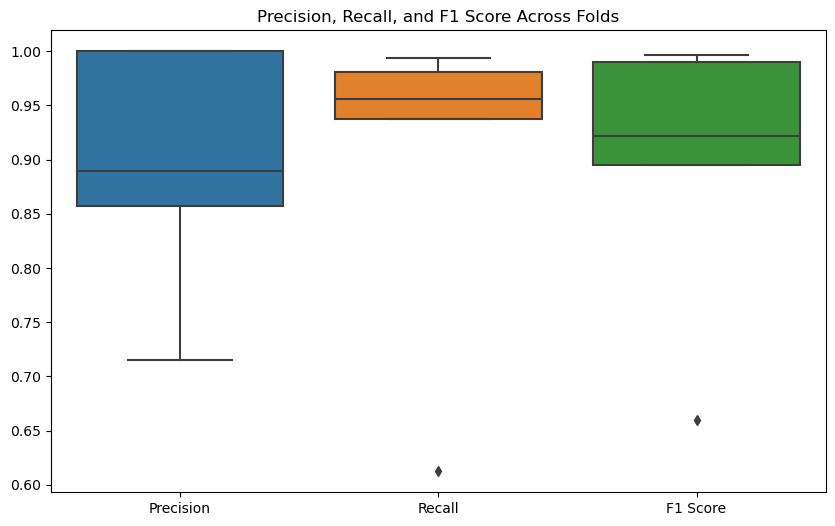


Summary of Results:
   Fold  Accuracy  Precision   Recall  F1 Score
0     1  0.684375   0.715328  0.61250  0.659933
1     2  0.890625   0.857143  0.93750  0.895522
2     3  0.918750   0.889535  0.95625  0.921687
3     4  0.990625   1.000000  0.98125  0.990536
4     5  0.996875   1.000000  0.99375  0.996865
Precision List: [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
Recall List: [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
F1 List: [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]


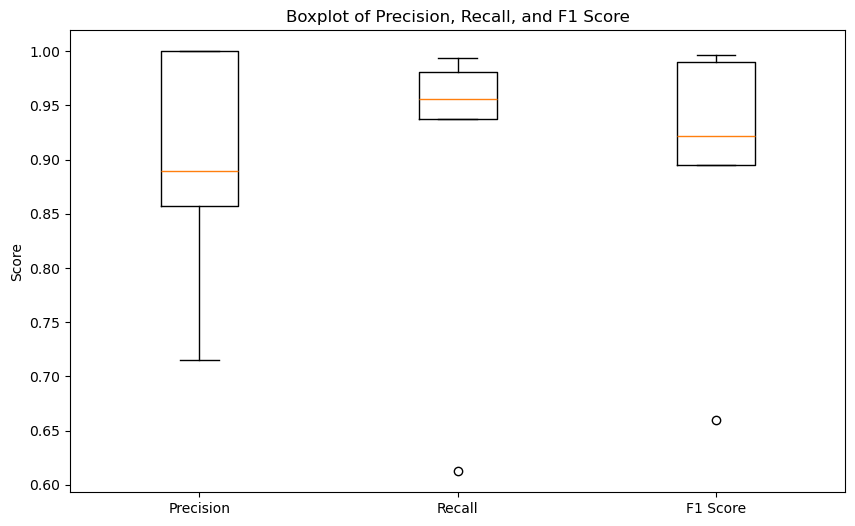

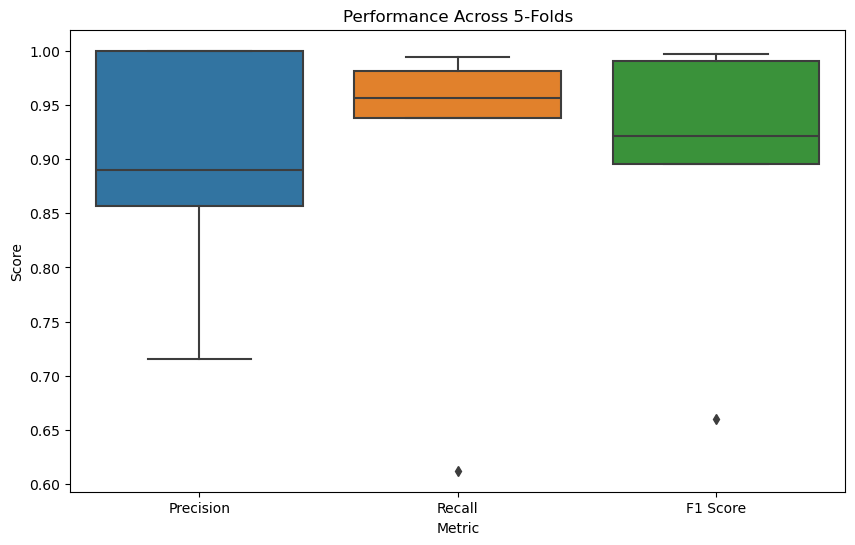


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
F1 Score     0.659933   0.892909   0.996865
Precision    0.715328   0.892401   1.000000
Recall       0.612500   0.896250   0.993750


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


import matplotlib.pyplot as plt


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



K fold: 10 Folds, 90% training, 10% testing split. (2 HI, 2 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 90-10 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


2023-11-24 15:48:43.961558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________


2023-11-24 15:48:48.538831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 15:48:48.544169: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0         
 2D)                                                             
          

In [2]:

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-10: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-10: {std_accuracy}')


Accuracies for each fold:
Fold 1: 0.731249988079071
Fold 2: 0.9312499761581421
Fold 3: 0.9937499761581421
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 1.0
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 1.0

Average Accuracy across Folds 1-10: 0.9656249940395355
Standard Deviation of Accuracy across Folds 1-10: 0.08073152242833005
